# Objective
#### Determine whether the given reviews are positive or negative using all features except SCORE and then check the accuracy using the Score feature using KNN classifier

# 1. Loading data from dataset

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import nltk
import seaborn as sns

In [2]:
# Loading data from sqlite3 database ignoring those having rewiew score = 3

connection = sqlite3.connect('./database.sqlite')
dataset = pd.read_sql_query("SELECT * FROM Reviews WHERE Score != 3", connection)

In [3]:
print("The shape of the data in dataset is:", dataset.shape)
print('==' * 60)
dataset.columns                # This will list all the features name in dataset column-wise

The shape of the data in dataset is: (525814, 10)


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [4]:
# Assigning Positive value to reviews with score>3 and Negative value to reviews with score<3

def assign_pn(score):
    if (score > 3):
        score = 'Positive'
    elif (score < 3):
        score = 'Negative'
    return score

pn = dataset['Score']
pn_assign = pn.map(assign_pn)
dataset['Score'] = pn_assign

In [5]:
print(dataset['Score'].value_counts() )                       # Printing the number of each classes (positive and negative reviews)
print('==' * 60)
print("The shape of the data in dataset is:", dataset.shape)

Positive    443777
Negative     82037
Name: Score, dtype: int64
The shape of the data in dataset is: (525814, 10)


In [6]:
# Printing first few rows as a sample of the dataset
# You may pass the number of rows to be displayed as an argument to the head() method

dataset.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 2. Pre-processing of data

### 2.1 De-duplication of data

In [7]:
# Sorting data based on ProductId

sorted_data = dataset.sort_values('ProductId', ascending=True, axis=0)
sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,Positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,Positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,Positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,Positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [8]:
# Remove all the data points that exactly match the field values mention below

data = sorted_data.drop_duplicates(subset={'UserId', 'Time', 'Text'}, keep='first', inplace=False)
data.shape

(364133, 10)

In [9]:
# Check what percentage of original data is remaining

percentage = (data.shape[0] / dataset.shape[0]) * 100
print(percentage)

69.25129418387492


In [10]:
# Removing the reviews having HelpfulnessNumerator greater than HelpfulnessDenominator

data = data[data.HelpfulnessDenominator >= data.HelpfulnessNumerator]
data.shape

(364131, 10)

Positive    307026
Negative     57105
Name: Score, dtype: int64

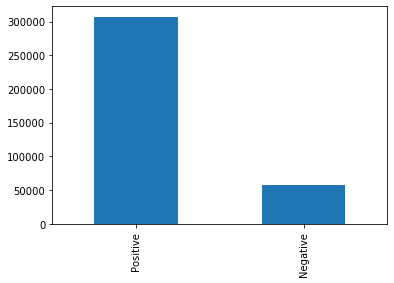

In [11]:
# Getting the number of positive and negative reviews

data['Score'].value_counts().plot(kind='bar')
data['Score'].value_counts()

### 2.2 Data Cleaning

In [12]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [13]:
# Find sentences containing html tags

i = 0
for sentence in data['Text'].values:
    if (len(re.findall('<.*?>', sentence))):
        print("Total number of html tags present:", i)
        print("=="*60)
        print(sentence)
        break
    i += 1

Total number of html tags present: 6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [14]:
# Function to remove texts with html tags(<...>)

def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')                  # Select ANY text with < > tags
    cleanText = re.sub(cleanr, ' ', sentence)     # Replace texts enclosed in < > with white space
    return cleanText

In [15]:
# Function to remove punctuation marks(.,?/:;)

def cleanPunctuation(sentence):
    cleanp = re.sub(r'[?|$|.|!]',r'', sentence)
    cleanp = re.sub(r'[.|,|)|(|\|/]',r' ', cleanp)
    return cleanp

In [16]:
# Printing the set of stop words present in english language
# You need to download stopword first before using it(import nltk; nltk.download("stopwords");)

stopWords = set(stopwords.words('english'))
print(stopWords)

{'during', 'most', 'or', "hasn't", 'where', 'did', 'between', 'they', 'mightn', 'my', 'this', 'as', 'while', 'couldn', 'an', "that'll", 'll', 'too', 'haven', 'don', 'these', 'again', 'how', 'just', 'ain', 'who', 'before', 'herself', 'is', 'yourselves', 'theirs', 'd', 'for', 'and', 'which', "hadn't", 'can', 'above', 'other', 'doing', 'have', "you're", 'such', 'her', 'over', "doesn't", "mightn't", 'be', 'has', 'doesn', 'wouldn', 'because', 's', 'down', 'some', 'each', 'a', 'should', "shan't", 'me', 'aren', 'him', 'both', 'needn', 'he', 'then', 'more', 'o', "she's", 'so', 'not', 'to', 'same', 'hadn', 'yours', 'few', 'shan', "wasn't", 'shouldn', "won't", 'against', 'am', 'that', 've', 'than', 'having', 'will', 'no', 'you', 're', 'when', 'on', 'its', 'myself', 'ourselves', "you've", 'been', 'but', 'up', "mustn't", 'further', "didn't", 'm', 'his', 'being', "you'll", "weren't", 'won', 'ma', "wouldn't", "needn't", 'in', 'the', 'were', 'it', 'off', 'once', 'their', 'mustn', 'about', 'whom', 'ou

In [17]:
# Initializing SnowBall Stemmer

snowball = SnowballStemmer('english')

In [18]:
# Printing a base-word using snowball stemmer

print(snowball.stem('tasty'))
print(snowball.stem('delicious'))
print(snowball.stem('little'))

tasti
delici
littl


In [19]:
# Core Pre-processing code step-by-step(removing html tags, punctuations, stopwords, etc)
# This may take a few minutes to execute as it needs to execute all the sentences present in data['Text']

i = 0
initial_str = ''
final_str = []          # Store final string of clean words
positive_words = []     # Store words from positive reviews here
negative_words = []     # Store words from negative reviews here
s = ''

for sentence in data['Text'].values:
    filtered_sentence = []
    sentence = cleanHtml(sentence)          # Remove html tags
    for words in sentence.split():
        for word in cleanPunctuation(words).split():
            if ((word.isalpha()) & (len(word) > 2)):
                if (word.lower() not in stopWords):
                    s = (snowball.stem(word.lower()).encode('utf-8'))
                    filtered_sentence.append(s)
                    if ((data['Score'].values)[i] == 'Positive'):
                        positive_words.append(s)
                    if ((data['Score'].values)[i] == 'Negative'):
                        negative_words.append(s)
                else:
                    continue
            else:
                continue
    initial_str = b" ".join(filtered_sentence)      # Final string of clean words
    final_str.append(initial_str)
    i += 1

In [20]:
# Adding a column in dataset and storing cleaned text in it.

data['CleanedText'] = final_str
data['CleanedText'] = data['CleanedText'].str.decode("utf-8")

In [21]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,Positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,Positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,Positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,Positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


# 3. Time-based splitting of data

In [22]:
# Sorting data based on time

time_sort = data.sort_values('Time', ascending=True, axis=0, na_position='last')       # na_postion='last' puts NaNs at the end
time_sort.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,Positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,Positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,Positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,Positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [23]:
from sklearn.model_selection import train_test_split

In [24]:
# Splitting data into Train, Test and Cross-validation

X = time_sort['CleanedText']
Y = time_sort['Score']

x_training, x_test, y_training, y_test= train_test_split(X, Y, test_size=0.25)
x_train, x_cv, y_train, y_cv = train_test_split(x_training, y_training, test_size=0.3)

In [25]:
print("The shape of the training data is:", x_train.shape, y_train.shape)
print("The shape of the CV data is:", x_cv.shape, y_cv.shape)
print("The shape of the test data is:", x_test.shape, y_test.shape)

The shape of the training data is: (191168,) (191168,)
The shape of the CV data is: (81930,) (81930,)
The shape of the test data is: (91033,) (91033,)


# 4. Function to Train and Test Logistic Regression models

In [26]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

### 4.1 Train function for Logistic Regression models

In [63]:
def logistic_train(x_train, x_cv, y_train, y_cv, penal):
    C = [10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001]
    accuracy_cv = []

    for i in C[0:]:
        logistic = LogisticRegression(penalty=penal, C=i)
        logistic.fit(x_train, y_train)
        
        prediction = logistic.predict(x_cv)
        
        acc_cv = accuracy_score(y_cv, prediction)
        f1_cv = f1_score(y_cv, prediction, average='macro')
        precision_cv = precision_score(y_cv, prediction, average='macro')
        recall_cv = recall_score(y_cv, prediction, average='macro')
        
        print("FOR λ =", i)
        print("The accuracy of the model is:", acc_cv*100)
        print("The f1_score of the model is:", f1_cv*100)
        print("The precision_score of the model is:", precision_cv*100)
        print("The recall_score of the model is:", recall_cv*100)
        print("=="*60)
        
        accuracy_cv.append(acc_cv)
        
    # Plot λ vs auc_score graph
    plt.plot(C, accuracy_cv, 'b-', label="Cross Validation Data")
    plt.legend(loc='lower right')
    plt.title("λ v/s Auc Score")
    plt.ylabel('Auc Score')
    plt.xlabel('λ')
    plt.show()

### 4.2 Test function for Logistic Regression models

In [28]:
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_confusion_matrix

In [64]:
def logistic_test(x_train, y_train, x_test, y_test, penal, optimal_C):
    logistic = LogisticRegression(penalty=penal, C=optimal_C)
    logistic.fit(x_train, y_train)
    
    prediction = logistic.predict(x_test)

    print("The accuracy of the model is:", accuracy_score(y_test, prediction)*100)
    print("The macro f1_score of the model is:", f1_score(y_test, prediction, average = 'macro')*100)
    print("The micro f1_score of the model is:", f1_score(y_test, prediction, average = 'micro')*100)
    print("The precision_score of the model is:", precision_score(y_test, prediction, average='macro')*100)
    print("The recall_score of the model is:", recall_score(y_test, prediction, average='macro')*100)
    print("The precision recall report for data:\n", classification_report(y_test, prediction))
    
    plot_confusion_matrix(y_test, prediction)
    plt.show()

# 5. Vectorization of splitted of data

### 5.1 Bag of Words (BoW)

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

In [33]:
count_vect = CountVectorizer(ngram_range=(2,2))
count_vect.fit(x_train)
# Fit should be done only to train data
# After fitting count_vect only learns the vocabulary of x_train i.e unique words(unique n-grams)

# To convert the SENTENCE into numerical vectors, we call transform()
x_train_bow = count_vect.transform(x_train)
x_cv_bow = count_vect.transform(x_cv)
x_test_bow = count_vect.transform(x_test)

In [34]:
print("The shape of the training data is:", x_train_bow.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_bow.shape, y_cv.shape)
print("The shape of the test data is:", x_test_bow.shape, y_test.shape)

The shape of the training data is: (191168, 1859088) (191168,)
The shape of the CV data is: (81930, 1859088) (81930,)
The shape of the test data is: (91033, 1859088) (91033,)


### 5.2 Term Frequency - Inverse Document Frequency (tf-idf)

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
tfidf_vect = TfidfVectorizer(stop_words=None, ngram_range=(1,2))
tfidf_vect.fit(x_train)
# Fit should be done only to train data
# After fitting tfidf_vect only learnss the vocabulary of x_train i.e unique words(unique n-grams)

# To convert the SENTENCE into numerical vectors, we call transform()
x_train_tfidf = tfidf_vect.transform(x_train)
x_cv_tfidf = tfidf_vect.transform(x_cv)
x_test_tfidf = tfidf_vect.transform(x_test)

In [37]:
print("The shape of the training data is:", x_train_tfidf.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_tfidf.shape, y_cv.shape)
print("The shape of the test data is:", x_test_tfidf.shape, y_test.shape)

The shape of the training data is: (191168, 1925065) (191168,)
The shape of the CV data is: (81930, 1925065) (81930,)
The shape of the test data is: (91033, 1925065) (91033,)


### 5.3 Word2Vec

In [38]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm

In [39]:
sentence_list = []
for sentence in x_train:
    sentence_list.append(sentence.split())

In [40]:
sentence_list_cv = []
for sentence in x_cv:
    sentence_list_cv.append(sentence.split())

In [41]:
sentence_list_test = []
for sentence in x_test:
    sentence_list_test.append(sentence.split())

In [42]:
# Train your own Word2Vec model using your own train text corpus 

w2v_train_model = Word2Vec(sentence_list, min_count=5, size=50, workers=4)          # Considers only those words that occured atleast 5 times
print(type(w2v_train_model))

<class 'gensim.models.word2vec.Word2Vec'>


In [43]:
w2v_words = list(w2v_train_model.wv.vocab)
print("The number of words that occured minimum 5 times:", len(w2v_words))
print("These are the sample words from index 0 to 50:/n", w2v_words[0:50])

The number of words that occured minimum 5 times: 16438
These are the sample words from index 0 to 50:/n ['sister', 'happen', 'pick', 'alittl', 'tin', 'way', 'visit', 'dad', 'christma', 'time', 'order', 'second', 'nephew', 'ate', 'anoth', 'car', 'trip', 'picki', 'eater', 'shock', 'super', 'delici', 'pepperi', 'chewey', 'sweet', 'take', 'scissor', 'snip', 'end', 'get', 'thembut', 'pinch', 'manag', 'open', 'anybodi', 'recommend', 'compar', 'better', 'pleas', 'let', 'know', 'exact', 'like', 'one', 'wish', 'write', 'wrapper', 'italian', 'great', 'product']


### 5.4 Average Word2Vec

In [44]:
avg_train_vector = []                         # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list):          # For each sentence/review
    sentence_vector = np.zeros(50)            # As word vectors are of zero length
    count_words = 0                           # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            sentence_vector += vect
            count_words += 1
        except:
            pass
    if count_words != 0:
        sentence_vector /= count_words
    avg_train_vector.append(sentence_vector)
avg_train_vector = np.array(avg_train_vector)

100%|██████████| 191168/191168 [00:20<00:00, 9229.05it/s]


In [45]:
print(avg_train_vector.shape)
print(avg_train_vector[0])

(191168, 50)
[-0.42505525  0.05246307  0.06110543  0.63659899 -0.16502366 -0.12412487
 -0.14280805  0.56053016  0.35442875 -0.2040802   0.25867109 -0.09242255
 -0.21184636  0.33377277 -1.02729689  0.57407513  0.2272895  -0.82739074
 -0.55133148  0.20602238  0.8207726   0.04122683  0.14204333 -0.51055601
 -0.1549338   0.07076684 -0.13638828 -0.22140719 -0.01406799 -0.55774234
 -0.46127964  0.03244384  0.201478    0.05210141  0.02739989  0.3568302
 -0.82133571 -0.36303814  0.24320763 -0.25974515 -0.46025425  0.07000492
 -0.0198881   0.61460745  0.03974825  0.06636203  0.11134815  0.26491626
 -0.42289911 -0.07568547]


In [46]:
avg_cv_vector = []                            # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list_cv):       # For each sentence/review
    sentence_vector = np.zeros(50)            # As word vectors are of zero length
    count_words = 0                           # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            sentence_vector += vect
            count_words += 1
        except:
            pass
    if count_words != 0:
        sentence_vector /= count_words
    avg_cv_vector.append(sentence_vector)
avg_cv_vector = np.array(avg_cv_vector)

100%|██████████| 81930/81930 [00:09<00:00, 9058.91it/s]


In [47]:
print(avg_cv_vector.shape)
print(avg_cv_vector[0])

(81930, 50)
[-0.21222063 -0.07157615  0.60007913  1.18896816 -0.81767389  0.7598202
 -0.33869641  0.37305436  0.64834905  0.3886594   0.77061974 -0.16828544
 -0.38840446  1.01557318 -0.92182916 -0.39073752  0.45641623 -0.84747813
 -1.19925078  1.39690347  0.4527873   0.03587674 -1.26465714 -0.59186602
 -0.99568404 -0.66921323 -0.13491624  0.42732279 -0.6025843  -0.69586534
 -0.94021301 -0.42923505 -0.01376375 -0.05904057  0.53101464  0.1689529
 -0.7321566   0.97121871  0.48042272 -0.44215428 -0.80540256 -0.0542059
 -0.06770056  0.79892484  0.78105402 -0.5019036   0.77432709  0.3428025
 -0.44609956 -0.10631703]


In [48]:
avg_test_vector = []                          # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list_test):     # For each sentence/review
    sentence_vector = np.zeros(50)            # As word vectors are of zero length
    count_words = 0                           # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            sentence_vector += vect
            count_words += 1
        except:
            pass
    if count_words != 0:
        sentence_vector /= count_words
    avg_test_vector.append(sentence_vector)
avg_test_vector = np.array(avg_test_vector)

100%|██████████| 91033/91033 [00:10<00:00, 9067.74it/s]


In [49]:
print(avg_test_vector.shape)
print(avg_test_vector[0])

(91033, 50)
[-1.45123515  0.80277494  0.44174399 -0.52264158 -0.23406817 -1.16753422
 -2.47687113 -0.31359918  0.8191296  -0.30508598 -0.01070105  0.72628129
 -0.83800774  0.78211894 -0.41872388 -0.10329406 -0.95118644  1.35699128
 -0.06579007 -0.1639323  -0.46961781  0.58563619  1.30388233  0.15227673
 -0.11237056 -1.38939469 -0.81048942 -0.67752496 -1.06355561  0.87646242
  0.75004006 -1.12752996  1.19181518  0.55872084  0.45733098 -0.11709492
 -0.10591994 -0.93629123  0.83517947  0.80876279 -0.65351731 -1.32904172
  0.00690897  0.35601771  2.2691754   0.41081945  0.66705524 -0.65617388
  0.26405643 -0.63112875]


In [50]:
x_train_avgw2v = avg_train_vector
x_cv_avgw2v = avg_cv_vector
x_test_avgw2v = avg_test_vector

In [51]:
print("The shape of the training data is:", x_train_avgw2v.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_avgw2v.shape, y_cv.shape)
print("The shape of the test data is:", x_test_avgw2v.shape, y_test.shape)

The shape of the training data is: (191168, 50) (191168,)
The shape of the CV data is: (81930, 50) (81930,)
The shape of the test data is: (91033, 50) (91033,)


### 5.5 TF-IDF Weighed Word2Vec

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [53]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tfidf_vect.fit_transform(x_train)
tfidf_feat = tfidf_vect.get_feature_names()
dictionary = dict(zip(tfidf_feat, list(tfidf_vect.idf_)))

In [54]:
tfidf_train_vector = []                         # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list):            # For each sentence/review
    sentence_vector = np.zeros(50)              # As word vectors are of zero length
    weight_sum = 0                              # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            tfidf_weight = dictionary[word]*(sentence.count(word)/len(sentence))
            sentence_vector += (vect*tfidf_weight)
            weight_sum += tfidf_weight
        except:
            pass
    if weight_sum != 0:
        sentence_vector /= weight_sum
    tfidf_train_vector.append(sentence_vector)
tfidf_train_vector = np.array(tfidf_train_vector)

100%|██████████| 191168/191168 [00:42<00:00, 4490.04it/s]


In [55]:
print(tfidf_train_vector.shape)
print(tfidf_train_vector[0])

(191168, 50)
[ 0.57749068  0.34117331 -0.42699427  0.17194403 -0.8206966   0.37593105
 -0.43102272  0.36060481  0.53276756 -0.35815466  0.26415967 -0.2296975
 -0.33105383  0.67844797 -1.57238362  0.36233708  0.73633744 -1.35151197
 -0.67376052  0.55172413  1.2381796  -0.10482816  0.25459147 -1.12429567
 -0.60472773  0.1225611  -0.24826543 -0.38008376 -0.28128494 -1.00312261
 -0.34692094 -0.02465986  0.52615415  0.6922397   0.53462373  0.09676299
 -1.46569156 -0.8749269  -0.35874219  0.07575747 -0.62520933 -0.73474396
  0.38608934  0.66632822 -0.23647541 -0.26657316  0.06928939  0.12959573
 -0.31540844 -0.42124565]


In [56]:
tfidf_cv_vector = []                            # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list_cv):         # For each sentence/review
    sentence_vector = np.zeros(50)              # As word vectors are of zero length
    weight_sum = 0                              # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            tfidf_weight = dictionary[word]*(sentence.count(word)/len(sentence))
            sentence_vector += (vect*tfidf_weight)
            weight_sum += tfidf_weight
        except:
            pass
    if weight_sum != 0:
        sentence_vector /= weight_sum
    tfidf_cv_vector.append(sentence_vector)
tfidf_cv_vector = np.array(tfidf_cv_vector)

100%|██████████| 81930/81930 [00:19<00:00, 4246.43it/s]


In [57]:
print(tfidf_cv_vector.shape)
print(tfidf_cv_vector[0])

(81930, 50)
[-0.32177509  0.05158948  0.59436251  1.55267331 -1.11961259  1.17153092
 -0.30723866  0.25906532  0.94462751  0.19943822  0.65921645 -0.31023654
 -0.71555248  1.07287052 -0.94256752 -0.07020187  0.64580557 -0.66555895
 -0.96230415  1.54627863  0.36386286 -0.38325606 -1.5843535  -1.03432862
 -1.13036817 -1.42898491 -0.45867928  0.2665268  -0.40568776 -0.61578511
 -1.29533842 -0.39684655  0.04406344 -0.27394502  0.74302811  0.16494407
 -0.84950197  1.54810672  0.84239954 -0.04225276 -1.02622583 -0.48404066
  0.41736671  0.79393658  1.21906882 -0.47710208  0.79316992 -0.26596849
 -0.46906653 -0.36306775]


In [58]:
tfidf_test_vector = []                          # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list_test):       # For each sentence/review
    sentence_vector = np.zeros(50)              # As word vectors are of zero length
    weight_sum = 0                              # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            tfidf_weight = dictionary[word]*(sentence.count(word)/len(sentence))
            sentence_vector += (vect*tfidf_weight)
            weight_sum += tfidf_weight
        except:
            pass
    if weight_sum != 0:
        sentence_vector /= weight_sum
    tfidf_test_vector.append(sentence_vector)
tfidf_test_vector = np.array(tfidf_test_vector)

100%|██████████| 91033/91033 [00:21<00:00, 4207.45it/s]


In [59]:
print(tfidf_test_vector.shape)
print(tfidf_test_vector[0])

(91033, 50)
[-1.65888006  0.79100521  0.01112612 -0.32487492 -0.13691861 -1.6695329
 -3.87079794 -0.41307484  1.56293208 -0.22377104  0.22596498  1.70221732
 -0.66254419  1.02674625 -0.61732471 -0.02811603 -1.66175278  1.95088601
 -0.28375477 -0.06660182 -0.76338234  0.22189861  2.11952134  0.02578359
 -0.4312652  -2.0983392  -1.26709912 -0.42633118 -1.40280558  0.75756435
  1.27529115 -1.42369645  1.52172344  0.68290058  0.34461057  0.23511346
 -0.3615142  -1.78163452  1.54661616  0.71427991 -1.86915205 -2.14155034
 -0.08450046  0.06591893  3.20154815  0.8240709   0.76778625 -1.15286421
 -0.11420254 -0.92789403]


In [60]:
x_train_tfidfw2v = tfidf_train_vector
x_cv_tfidfw2v = tfidf_cv_vector
x_test_tfidfw2v = tfidf_test_vector

In [61]:
print("The shape of the training data is:", x_train_tfidfw2v.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_tfidfw2v.shape, y_cv.shape)
print("The shape of the test data is:", x_test_tfidfw2v.shape, y_test.shape)

The shape of the training data is: (191168, 50) (191168,)
The shape of the CV data is: (81930, 50) (81930,)
The shape of the test data is: (91033, 50) (91033,)


# 6. Applying Logistic Regression L2 Regularization on Our Model

### 6.1 Bag of Words (BoW)

##### 6.1.1 BoW Logistic Regression L2 Regularization on Train Data

FOR λ = 10000
The accuracy of the model is: 91.20956914439155
The f1_score of the model is: 81.79101359083197
The precision_score of the model is: 85.80765016500408
The recall_score of the model is: 78.93346223862926
FOR λ = 5000
The accuracy of the model is: 91.26327352618088
The f1_score of the model is: 81.91146838714518
The precision_score of the model is: 85.91653997620041
The recall_score of the model is: 79.05622772377666
FOR λ = 1000
The accuracy of the model is: 91.2779201757598
The f1_score of the model is: 81.79196536109194
The precision_score of the model is: 86.21503578022742
The recall_score of the model is: 78.72965536850747
FOR λ = 500
The accuracy of the model is: 91.23275967289149
The f1_score of the model is: 81.63753213794732
The precision_score of the model is: 86.21581401557216
The recall_score of the model is: 78.50542955876215
FOR λ = 100
The accuracy of the model is: 91.15586476260222
The f1_score of the model is: 81.25911113147635
The precision_score of the mo

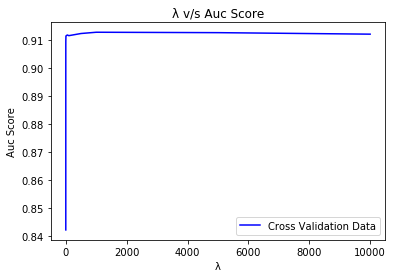

In [63]:
# Find the optimal value of C
# This may take several minutes(even hour/s) to run

logistic_train(x_train_bow, x_cv_bow, y_train, y_cv, penal='l2')

##### 6.1.2 BoW Logistic Regression L2 Regularization on Test Data

The accuracy of the model is: 91.29766128766491
The macro f1_score of the model is: 81.78456001616456
The micro f1_score of the model is: 91.29766128766491
The precision_score of the model is: 86.40984796831226
The recall_score of the model is: 78.625279025407
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.80      0.60      0.69     14418
    Positive       0.93      0.97      0.95     76615

    accuracy                           0.91     91033
   macro avg       0.86      0.79      0.82     91033
weighted avg       0.91      0.91      0.91     91033



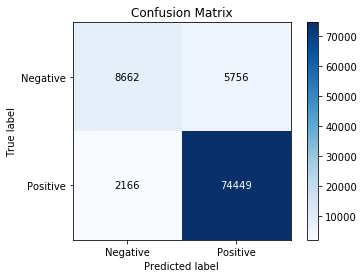

In [64]:
# Testing the final model

logistic_test(x_train_bow, y_train, x_test_bow, y_test, penal='l2', optimal_C=1000)

### 6.2 Term Frequency - Inverse Document Frequency (tf-idf)

##### 6.2.1 TF-IDF Logistic Regression L2 Regularization on Train Data

FOR λ = 10000
The accuracy of the model is: 93.30404003417551
The f1_score of the model is: 86.82870760615275
The precision_score of the model is: 88.75320030175583
The recall_score of the model is: 85.18147125537952
FOR λ = 5000
The accuracy of the model is: 93.26864396435982
The f1_score of the model is: 86.74613771495822
The precision_score of the model is: 88.71145260850074
The recall_score of the model is: 85.06957990573834
FOR λ = 1000
The accuracy of the model is: 93.35896497009642
The f1_score of the model is: 86.8044585629348
The precision_score of the model is: 89.20340534339239
The recall_score of the model is: 84.81928777757159
FOR λ = 500
The accuracy of the model is: 93.34431832051752
The f1_score of the model is: 86.8060084800173
The precision_score of the model is: 89.09345797423916
The recall_score of the model is: 84.89832311012808
FOR λ = 100
The accuracy of the model is: 93.37727328207006
The f1_score of the model is: 86.77064461866732
The precision_score of the mod

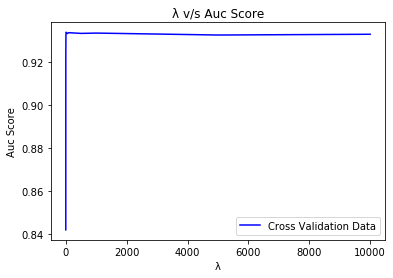

In [65]:
# Find the optimal value of C
# This may take several minutes to run

logistic_train(x_train_tfidf, x_cv_tfidf, y_train, y_cv, penal='l2')

##### 6.2.2 TF-IDF Logistic Regression L2 Regularization on Test Data

The accuracy of the model is: 93.17060846066812
The macro f1_score of the model is: 86.23323809030255
The micro f1_score of the model is: 93.17060846066812
The precision_score of the model is: 89.36196286354287
The recall_score of the model is: 83.77790309518237
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.84      0.70      0.76     14418
    Positive       0.95      0.98      0.96     76615

    accuracy                           0.93     91033
   macro avg       0.89      0.84      0.86     91033
weighted avg       0.93      0.93      0.93     91033



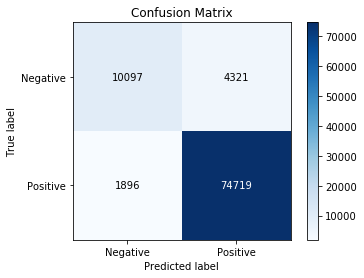

In [66]:
# Testing the final model

logistic_test(x_train_tfidf, y_train, x_test_tfidf, y_test, penal='l2', optimal_C=10)

### 6.3 Average Word2vec

##### 6.3.1 Avg W2V Logistic Regression L2 Regularization on Train Data

FOR λ = 10000
The accuracy of the model is: 89.48614671060662
The f1_score of the model is: 77.18116555557918
The precision_score of the model is: 82.96937509509887
The recall_score of the model is: 73.75498169077748
FOR λ = 5000
The accuracy of the model is: 89.48492615647504
The f1_score of the model is: 77.17940435715722
The precision_score of the model is: 82.96507676655796
The recall_score of the model is: 73.75425674841041
FOR λ = 1000
The accuracy of the model is: 89.48614671060662
The f1_score of the model is: 77.18116555557918
The precision_score of the model is: 82.96937509509887
The recall_score of the model is: 73.75498169077748
FOR λ = 500
The accuracy of the model is: 89.48614671060662
The f1_score of the model is: 77.18116555557918
The precision_score of the model is: 82.96937509509887
The recall_score of the model is: 73.75498169077748
FOR λ = 100
The accuracy of the model is: 89.48614671060662
The f1_score of the model is: 77.18116555557918
The precision_score of the m

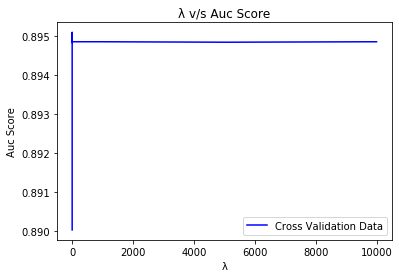

In [67]:
# Find the optimal value of C
# This may take several minutes to run

logistic_train(x_train_avgw2v, x_cv_avgw2v, y_train, y_cv, penal='l2')

##### 6.3.2 Avg W2V Logistic Regression L2 Regularization on Test Data

The accuracy of the model is: 89.57191348192414
The macro f1_score of the model is: 77.37890828808733
The micro f1_score of the model is: 89.57191348192414
The precision_score of the model is: 83.24059587736154
The recall_score of the model is: 73.91482967311549
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.75      0.51      0.61     14418
    Positive       0.91      0.97      0.94     76615

    accuracy                           0.90     91033
   macro avg       0.83      0.74      0.77     91033
weighted avg       0.89      0.90      0.89     91033



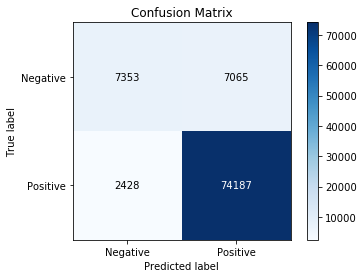

In [68]:
# Testing the final model

logistic_test(x_train_avgw2v, y_train, x_test_avgw2v, y_test, penal='l2', optimal_C=10)

### 6.4 TF_IDF Weighed Word2vec

##### 6.4.1 TF-IDF W2V Logistic Regression L2 Regularization on Train Data

FOR λ = 10000
The accuracy of the model is: 86.72159160258758
The f1_score of the model is: 67.3845884526067
The precision_score of the model is: 77.93267629647967
The recall_score of the model is: 63.988132800298615
FOR λ = 5000
The accuracy of the model is: 86.72159160258758
The f1_score of the model is: 67.3845884526067
The precision_score of the model is: 77.93267629647967
The recall_score of the model is: 63.988132800298615
FOR λ = 1000
The accuracy of the model is: 86.72159160258758
The f1_score of the model is: 67.3845884526067
The precision_score of the model is: 77.93267629647967
The recall_score of the model is: 63.988132800298615
FOR λ = 500
The accuracy of the model is: 86.72159160258758
The f1_score of the model is: 67.3845884526067
The precision_score of the model is: 77.93267629647967
The recall_score of the model is: 63.988132800298615
FOR λ = 100
The accuracy of the model is: 86.72281215671916
The f1_score of the model is: 67.38909205736338
The precision_score of the m

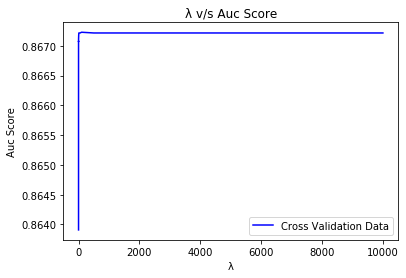

In [69]:
# Find the optimal value of C
# This may take several minutes to run

logistic_train(x_train_tfidfw2v, x_cv_tfidfw2v, y_train, y_cv, penal='l2')

##### 6.4.2 TF-IDF W2V Logistic Regression L2 Regularization on Test Data

The accuracy of the model is: 86.84323267386553
The macro f1_score of the model is: 67.74792823956766
The micro f1_score of the model is: 86.84323267386551
The precision_score of the model is: 78.42166572091138
The recall_score of the model is: 64.27583785656923
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.69      0.31      0.43     14418
    Positive       0.88      0.97      0.93     76615

    accuracy                           0.87     91033
   macro avg       0.78      0.64      0.68     91033
weighted avg       0.85      0.87      0.85     91033



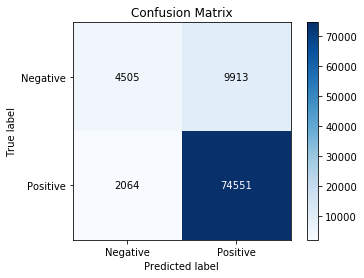

In [70]:
# Testing the final model

logistic_test(x_train_tfidfw2v, y_train, x_test_tfidfw2v, y_test, penal='l2', optimal_C=10)